# GenAI with Python

###### [Article: TowardsDataScience](https://towardsdatascience.com/genai-with-python-rag-with-llm-complete-tutorial-c276dda6707b)

### Data

In [3]:
#conda install -c conda-forge poppler
import pdf2image #1.17.0

doc_img = pdf2image.convert_from_path("D:/CourseIAGenAI/git/iagenai/fmi-2025-05-nlp_llm/RAG/data/doc_nvidia.pdf", dpi=300, poppler_path = r"D:\Programs\poppler-24.08.0\Library\bin")

print("pages:", len(doc_img))
doc_img[35]

pages: 96


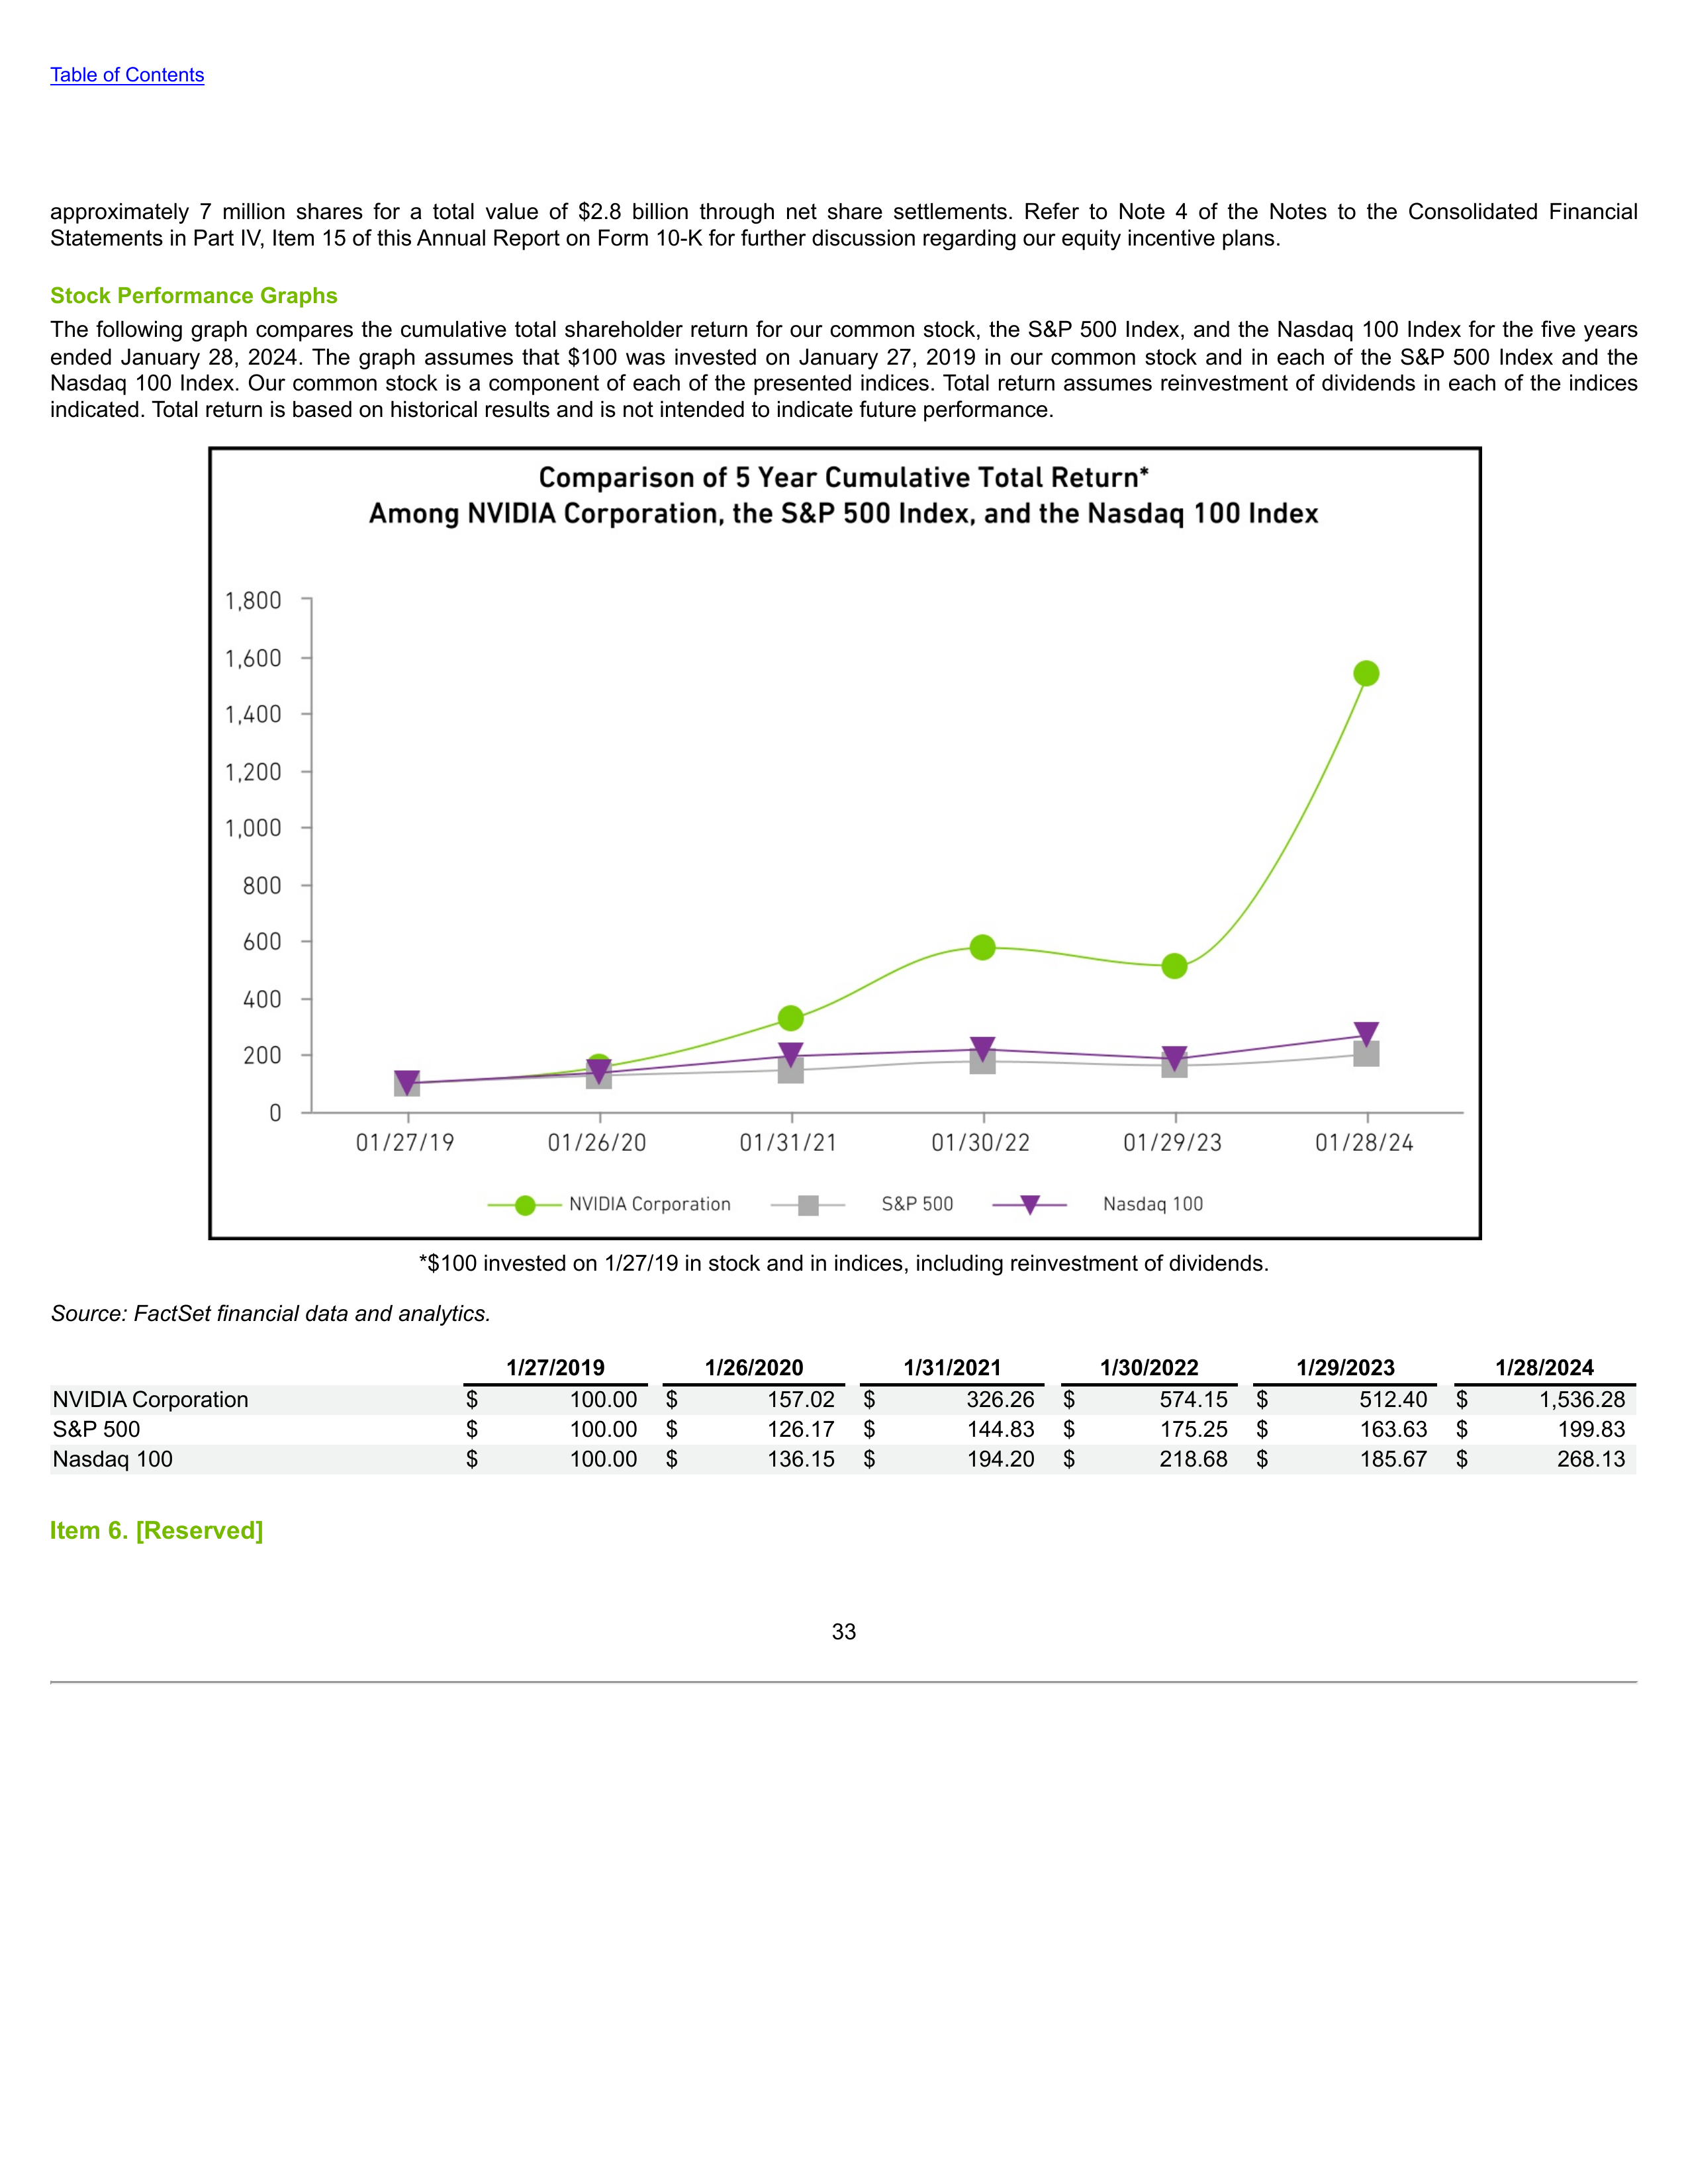

In [4]:
doc_img[32]

In [5]:
import pytesseract #0.3.13
from tqdm.notebook import tqdm

pytesseract.pytesseract.tesseract_cmd = r'D:\Program Files\Tesseract-OCR\tesseract.exe'

doc_txt = []
for page in tqdm(doc_img):
    text = pytesseract.image_to_string(page)
    doc_txt.append(text)

doc_txt[35]

  0%|          | 0/96 [00:00<?, ?it/s]

'Table of Contents\n\nFiscal Year 2024 Summary\n\nYear Ended\nJan 28, 2024 Jan 29, 2023 Change\n($ in millions, except per share data)\nRevenue $ 60,922 $ 26,974 Up 126%\nGross margin 72.7 % 56.9 % Up 15.8 pts\nOperating expenses $ 11,329 $ 11,132 Up 2%\nOperating income $ 32,972 $ 4,224 Up 681%\nNet income $ 29,760 $ 4,368 Up 581%\nNet income per diluted share $ 11.93 $ 1.74 Up 586%\n\nWe specialize in markets where our computing platforms can provide tremendous acceleration for applications. These platforms incorporate processors,\ninterconnects, software, algorithms, systems, and services to deliver unique value. Our platforms address four large markets where our expertise is critical: Data\nCenter, Gaming, Professional Visualization, and Automotive.\n\nRevenue for fiscal year 2024 was $60.9 billion, up 126% from a year ago.\n\nData Center revenue for fiscal year 2024 was up 217%. Strong demand was driven by enterprise software and consumer internet applications, and multiple\nindus

### Preprocessing

In [6]:
title_map = {
    "4-12":"Business",
    "13-33":"Risk Factors",
    "34-44":"Financials",
    "45-46":"Directors",
    "47-83":"Data"
}

In [7]:
lst_docs, lst_ids, lst_metadata = [], [], []
for n,page in enumerate(doc_txt):
    try:
        ## get title
        title = [v for k,v in title_map.items() if n in range(int(k.split("-")[0]), int(k.split("-")[1])+1)][0]
        ## clean page
        page = page.replace("Table of Contents","")
        ## get paragraph
        for i,p in enumerate(page.split('\n\n')):
            if len(p.strip())>5:
                lst_docs.append(p.strip())
                lst_ids.append(str(n)+"_"+str(i))
                lst_metadata.append({"title":title})
    except:
        continue

print(len(lst_docs), "=", len(lst_ids), "=", len(lst_metadata))

1081 = 1081 = 1081


In [8]:
for id,doc,meta in zip(lst_ids[375:378], lst_docs[375:378], lst_metadata[375:378]):
    print(id, "-", meta, "\n", doc, "\n")

35_1 - {'title': 'Financials'} 
 Fiscal Year 2024 Summary 

35_2 - {'title': 'Financials'} 
 Year Ended
Jan 28, 2024 Jan 29, 2023 Change
($ in millions, except per share data)
Revenue $ 60,922 $ 26,974 Up 126%
Gross margin 72.7 % 56.9 % Up 15.8 pts
Operating expenses $ 11,329 $ 11,132 Up 2%
Operating income $ 32,972 $ 4,224 Up 681%
Net income $ 29,760 $ 4,368 Up 581%
Net income per diluted share $ 11.93 $ 1.74 Up 586% 

35_3 - {'title': 'Financials'} 
 We specialize in markets where our computing platforms can provide tremendous acceleration for applications. These platforms incorporate processors,
interconnects, software, algorithms, systems, and services to deliver unique value. Our platforms address four large markets where our expertise is critical: Data
Center, Gaming, Professional Visualization, and Automotive. 



### LLM Generator

###### TEXT

In [12]:
import ollama #0.2.1

def keyword_generator(p, top=3):
    system = "Your main objective is to condense the content of the document into a concise summary of no more than 3 keywords, capturing the main points and themes. Produce ONLY 3 keywords, DO NOT generate more text."
    prompt = "summarize the following paragraph in 3 short keywords separated by comma(,):\n"+p + "\n"
    res = ollama.generate(model="llama3.2", system=system, prompt=prompt)["response"]
    #lst = [k.replace("\n"," ").strip() for k in res.split(",")][:top]
    #str = ", ".join(lst)
    return res.replace("\n"," ").strip()

# p = '''Professional artists, architects and designers use NVIDIA partner products accelerated with our GPUs and software platform for a range of creative and design
# use cases, such as creating visual effects in movies or designing buildings and products. In addition, generative Al is expanding the market for our workstation-
# class GPUs, as more enterprise customers develop and deploy Al applications with their data on-premises.'''
p = ''' Year Ended
Jan 28, 2024 Jan 29, 2023 Change
($ in millions, except per share data)
Revenue $ 60,922 $ 26,974 Up 126%
Gross margin 72.7 % 56.9 % Up 15.8 pts
Operating expenses $ 11,329 $ 11,132 Up 2%
Operating income $ 32,972 $ 4,224 Up 681%
Net income $ 29,760 $ 4,368 Up 581%
Net income per diluted share $ 11.93 $ 1.74 Up 586%'''
# p = '''We specialize in markets where our computing platforms can provide tremendous acceleration for applications. These platforms incorporate processors, interconnects,
# software, algorithms, systems, and services
#  to deliver unique value. Our platforms address four large markets where our expertise is critical: Data Center, Gaming, Professional Visualization, and Automotive.'''

print(keyword_generator(p))

Revenue, Gross Margin, Net Income


In [13]:
for i,doc in tqdm(enumerate(lst_docs)):
    lst_metadata[i]["keywords"] = keyword_generator(doc)

0it [00:00, ?it/s]

In [14]:
for id,doc,meta in zip(lst_ids[375:378], lst_docs[375:378], lst_metadata[375:378]):
    print(id, "-", meta, "\n", doc, "\n")

35_1 - {'title': 'Financials', 'keywords': 'Fiscal, Budget, Year'} 
 Fiscal Year 2024 Summary 

35_2 - {'title': 'Financials', 'keywords': 'Revenue, Gross Margin, Operating Income'} 
 Year Ended
Jan 28, 2024 Jan 29, 2023 Change
($ in millions, except per share data)
Revenue $ 60,922 $ 26,974 Up 126%
Gross margin 72.7 % 56.9 % Up 15.8 pts
Operating expenses $ 11,329 $ 11,132 Up 2%
Operating income $ 32,972 $ 4,224 Up 681%
Net income $ 29,760 $ 4,368 Up 581%
Net income per diluted share $ 11.93 $ 1.74 Up 586% 

35_3 - {'title': 'Financials', 'keywords': 'Computing Platforms, Acceleration, Markets'} 
 We specialize in markets where our computing platforms can provide tremendous acceleration for applications. These platforms incorporate processors,
interconnects, software, algorithms, systems, and services to deliver unique value. Our platforms address four large markets where our expertise is critical: Data
Center, Gaming, Professional Visualization, and Automotive. 



###### TABLE

In [15]:
table = lst_docs[376]
print("Table:\n", table)

prompt = f"Summarize the following table: {table}"
res = ollama.generate(model="llama3.2", prompt=prompt)["response"]

print("\nSummary:\n", res)

Table:
 Year Ended
Jan 28, 2024 Jan 29, 2023 Change
($ in millions, except per share data)
Revenue $ 60,922 $ 26,974 Up 126%
Gross margin 72.7 % 56.9 % Up 15.8 pts
Operating expenses $ 11,329 $ 11,132 Up 2%
Operating income $ 32,972 $ 4,224 Up 681%
Net income $ 29,760 $ 4,368 Up 581%
Net income per diluted share $ 11.93 $ 1.74 Up 586%

Summary:
 The table shows the financial performance of a company for two consecutive years. Here are the key highlights:

* Revenue increased by 126% from $26.9 billion to $60.9 billion.
* Gross margin improved by 15.8 percentage points, increasing from 56.9% to 72.7%.
* Operating expenses remained relatively stable at $11.3 million (up 2%).
* Operating income surged by 681%, jumping from $4.2 million to $32.9 million.
* Net income increased by 581%, rising from $4.3 million to $29.8 million.
* Net income per diluted share grew by 586%, increasing from $1.7 to $11.9.

Overall, the company experienced significant revenue growth, along with substantial imp

In [17]:
table = lst_docs[376]
print("Table:\n", table)

prompt = f"Give a concise summary of the following table: {table}"
res = ollama.generate(model="llama3.2", prompt=prompt)["response"]

print("\nSummary:\n", res)

Table:
 Year Ended
Jan 28, 2024 Jan 29, 2023 Change
($ in millions, except per share data)
Revenue $ 60,922 $ 26,974 Up 126%
Gross margin 72.7 % 56.9 % Up 15.8 pts
Operating expenses $ 11,329 $ 11,132 Up 2%
Operating income $ 32,972 $ 4,224 Up 681%
Net income $ 29,760 $ 4,368 Up 581%
Net income per diluted share $ 11.93 $ 1.74 Up 586%

Summary:
 The table shows a significant increase in financial performance for the company from January 29, 2023, to January 28, 2024. The key highlights are:

- Revenue increased by 126%, from $26.9 billion to $60.9 billion.
- Gross margin improved by 15.8 percentage points, to 72.7%.
- Operating expenses remained relatively stable, increasing only by 2%.
- Operating income and net income both experienced substantial growth, rising by 681% and 581%, respectively.
- Net income per diluted share increased by 586%.


###### IMAGES

In [19]:
from matplotlib import image, pyplot

image_file = "D:/CourseIAGenAI/git/iagenai/fmi-2025-05-nlp_llm/RAG/data/image.png"

pyplot.imshow(image.imread(image_file))
pyplot.show()

In [20]:
## Encode the image into a string
import base64

def encode_image(path):
    with open(path, "rb") as file:
        return base64.b64encode(file.read()).decode('utf-8')

img = encode_image(image_file)
img[:1000]

'iVBORw0KGgoAAAANSUhEUgAABFQAAAM+CAYAAAA0NVXiAAAKrWlDQ1BJQ0MgUHJvZmlsZQAASImVlwdQU+kWgP9700NCS4iAlNCb9BZASggtgIJ0EIWQBAglxEBQsSPiCq4FFRFUBF0VUHBViiwiIoqFRUDB7oIsCsq6WLCh8i4whN19896bd2bOnO+ee/5zzv/P/WfOBYAszxGJUmB5AFKFGeIgb3d6RGQUHTcMMIAG8EAd6HC46SJmYKA/QGTW/l0+9AFoyt4xncr17+//qyjw+OlcAKBAhON46dxUhM8j+pIrEmcAgDqC+HVWZoimuA1hqhhpEOH7U5www6NTHDfNaDAdExLEQpgKAJ7E4YgTACDRET89k5uA5CG5IWwh5AmECIsQdklNTeMhfAZhQyQG8ZGm8jPi/pIn4W8546Q5OZwEKc/sZVrwHoJ0UQpn9f95HP9bUlMkszX0ESUlin2CEKuInNn95DQ/KQvjFgfMsoA3HT/NiRKf0FnmprOiZpnH8fCTrk1Z7D/L8QIvtjRPBjtklvnpnsGzLE4LktaKF7OYs8wRz9WVJIdK/Yl8tjR/VmJI+CxnCsIWz3J6crDfXAxL6hdLgqT984Xe7nN1vaR7T03/y34FbOnajMQQH+neOXP984XMuZzpEdLeeHwPz7mYUGm8KMNdWkuUEiiN56d4S/3pmcHStRnIBzm3NlB6hkkc38BZBiyQBlIQFQM68EeePADI4K/KmNoIK020WixISMygM5EbxqezhVyzBXQrCysbAKbu68zn8I42fQ8h2s05X/YTAJwjJycnm+Z8/sh5nB8GgDg65zOoAoDcDMD1LVyJOHPGN32XMIAI5AAVqAANoAMMgSmwAnbACbgBT+ALAkAIiATLARckglSk85VgLdgEckE+2AX2gWJQCo6Ck+A0OAvqQRO4DK6BW6AL9IJHoB8MgVdgDHwAExAE4SAyRIFUIE1IDzKBrCAG5AJ5Qv5QEBQJxUIJkBC

In [21]:
prompt = "describe the image"
res = ollama.generate(model="llama3.2", prompt=prompt, images=[img])["response"]
print(res)

You haven't provided an image. Please share the image you'd like me to describe, and I'll do my best to provide a detailed description of it.


In [25]:
## qwen3-vl:8b
prompt = "describe the image"
res = ollama.generate(model="qwen3-vl:8b", prompt=prompt, images=[img])["response"]
print(res)

The image showcases two **graphics cards (GPUs)** placed against a vibrant yellow background.  

### Left Graphics Card:  
- **Brand/Model**: Gigabyte (identified by the "GIGABYTE" logo on each fan).  
- **Design**: Sleek, all-black casing with a matte finish.  
- **Cooling System**: Features **three large fans** arranged vertically. Each fan has a circular center with the "GIGABYTE" logo prominently displayed. The fan blades have a dark, ribbed texture.  
- **Aesthetic**: Angular, geometric patterns on the side panel, giving it a modern, aggressive look.  

### Right Graphics Card:  
- **Brand/Model**: NVIDIA RTX 2080 SUPER (clearly labeled on the card).  
- **Design**: Metallic silver/gold finish with a glossy, reflective surface.  
- **Cooling System**: Features **two large fans** arranged horizontally. Each fan has a circular, polished silver center.  
- **Branding**: Includes the text "RTX 2080 SUPER" (with "SUPER" in a green badge) and the "NVIDIA" logo near the PCIe connector. A

###### PLOTS

In [26]:
image_file = "D:/CourseIAGenAI/git/iagenai/fmi-2025-05-nlp_llm/RAG/data/plot.png"

pyplot.imshow(image.imread(image_file))
pyplot.show()

In [28]:
img = encode_image(image_file)

prompt = "Describe the image in detail. Be specific about graphs, such as bar plots"
res = ollama.generate(model="qwen3-vl:8b", prompt=prompt, images=[img])["response"]
print(res)

The image is a **grouped bar chart** titled "Sales" that visualizes sales data across three regions (Asia, USA, Europe) for three products (Product 1, Product 2, Product 3). Below is a detailed breakdown:  

### **1. Chart Structure**  
- **Title**: "Sales" is centered at the top.  
- **X-axis**: Labels the categories as *Product 1*, *Product 2*, and *Product 3* (each product is a group of bars).  
- **Y-axis**: Represents sales value, scaled from 0 to 5 with grid lines at integer intervals (0, 1, 2, 3, 4, 5).  
- **Legend**: Positioned at the bottom, with color coding:  
  - 🟦 Blue = *Asia*  
  - 🟠 Orange = *USA*  
  - 🟤 Gray = *Europe*  

---

### **2. Data Breakdown by Product**  

#### **Product 1**  
- **Asia (Blue bar)**: Height ≈ **4.25** (slightly above the 4 grid line).  
- **USA (Orange bar)**: Height ≈ **2.25** (slightly above the 2 grid line).  
- **Europe (Gray bar)**: Height = **2.0** (exactly at the 2 grid line).  
→ *Asia dominates Product 1 sales*, followed closely by 

### Database

In [29]:
import chromadb #1.4.0

db = chromadb.PersistentClient()
db.list_collections()

[]

In [30]:
collection_name = "nvidia"

if collection_name in [c.name for c in db.list_collections()]:
    db.delete_collection(collection_name)
    print("--- deleted ---")

collection = db.get_or_create_collection(name=collection_name, 
                                         embedding_function=chromadb.utils.embedding_functions.DefaultEmbeddingFunction())

collection.add(documents=lst_docs, ids=lst_ids, metadatas=lst_metadata, 
               images=None, embeddings=None)

collection.peek(1)

C:\Users\office27\.cache\chroma\onnx_models\all-MiniLM-L6-v2\onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:16<00:00, 5.09MiB/s]


{'ids': ['4_1'],
 'embeddings': array([[-9.74981859e-02, -3.10074147e-02,  2.04683430e-02,
          4.41562794e-02,  4.87011373e-02, -6.32695034e-02,
         -1.00582883e-01,  1.83412060e-02, -2.72620078e-02,
         -1.23763876e-02, -1.40804425e-01, -6.21848330e-02,
         -4.22603153e-02, -6.50530541e-03, -3.72276902e-02,
          4.71971184e-02, -1.06208641e-02, -4.11713421e-02,
         -3.45307365e-02, -1.04052447e-01, -1.89929698e-02,
          2.97947209e-02, -1.96872856e-02, -3.87388393e-02,
          2.22827606e-02,  2.71929260e-02, -5.73482476e-02,
         -2.27755047e-02, -1.79021489e-02,  4.55296859e-02,
          5.34584606e-03,  5.96850067e-02, -1.54073853e-02,
          1.26382085e-02, -3.26076113e-02,  2.27996614e-02,
         -5.38884774e-02, -6.75361007e-02, -2.88906842e-02,
         -5.68180904e-02,  3.26938666e-02, -2.70926431e-02,
          1.37217902e-02,  5.80371693e-02,  8.50114673e-02,
          6.93315221e-03,  2.38496121e-02,  2.01993249e-02,
         

In [31]:
query = "how much is the revenue?"
collection.query(query_texts=[query])

{'ids': [['78_13',
   '78_7',
   '54_11',
   '54_13',
   '37_1',
   '39_2',
   '35_4',
   '78_12',
   '69_5',
   '70_1']],
 'embeddings': None,
 'documents': [['Total revenue',
   'Total revenue $ 60,922 $ 26,974 $ 26,914',
   'Revenue Recognition',
   'Product Sales Revenue',
   'Revenue Recognition\nRevenue Allowances',
   'Concentration of Revenue',
   'Revenue for fiscal year 2024 was $60.9 billion, up 126% from a year ago.',
   'Revenue: (In millions)\nData Center 47,525 15,005 $ 10,613\nGaming 10,447 9,067 12,462\nProfessional Visualization 1,553 1,544 2,111\nAutomotive 1,091 903 566\nOEM and Other 306 455 1,162\n60,922 26,974 $ 26,914',
   '(2) Deferred revenue primarily includes customer advances and deferrals related to support for hardware and software, license and development arrangements, and cloud services. $233 million and\n$35 million of the balance in fiscal 2024 and 2023 respectively, related to customer advances.',
   'invoiced in future periods. Revenue allocated to 

In [32]:
res_db = collection.query(query_texts=[query])["documents"][0][0:10]
context = ' '.join(res_db).replace("\n", " ")
context

'Total revenue Total revenue $ 60,922 $ 26,974 $ 26,914 Revenue Recognition Product Sales Revenue Revenue Recognition Revenue Allowances Concentration of Revenue Revenue for fiscal year 2024 was $60.9 billion, up 126% from a year ago. Revenue: (In millions) Data Center 47,525 15,005 $ 10,613 Gaming 10,447 9,067 12,462 Professional Visualization 1,553 1,544 2,111 Automotive 1,091 903 566 OEM and Other 306 455 1,162 60,922 26,974 $ 26,914 (2) Deferred revenue primarily includes customer advances and deferrals related to support for hardware and software, license and development arrangements, and cloud services. $233 million and $35 million of the balance in fiscal 2024 and 2023 respectively, related to customer advances. invoiced in future periods. Revenue allocated to remaining performance obligations, which includes deferred revenue and amounts that will be invoiced and recognized as revenue in future periods, was $1.1 billion as of January 28, 2024. We expect to recognize approximatel

### LLM Chat

In [33]:
# Chat with Context only
res = ollama.chat(model="llama3.2", 
                  messages=[{"role":"system", "content":"Give the most accurate answer using only \
                                                         the folling information: \n"+context},
                            {"role":"user", "content":query}])
print(res["message"]["content"])

The total revenue for fiscal year 2024 was $60,922 million.


In [34]:
# Chat with knowledge + Context
res = ollama.chat(model="llama3.2", 
                  messages=[{"role":"system", "content":"Give the most accurate answer using your knowledge \
                                                         and the folling additional information: \n"+context},
                            {"role":"user", "content":query}])
print(res["message"]["content"])

The total revenue for fiscal year 2024 was $60,922 million.


In [36]:
# Chat Stream
res = ollama.chat(model="llama3.2", 
                  messages=[{"role":"system", "content":"Give the most accurate answer using your knowledge \
                                                         and the folling additional information: \n"+context},
                            {"role":"user", "content":query}],
                  stream=True)
for chunk in res:
    print(chunk["message"]["content"], end="")

The total revenue for fiscal year 2024 is $60,922 million.